<a href="https://colab.research.google.com/github/xavdx/Nutrition-Paradox/blob/main/Nutrition_Paradox_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install requests pycountry

In [2]:
import pandas as pd
import requests
import pycountry
import json

In [3]:
#Obesity
adult_obesity_url= "https://ghoapi.azureedge.net/api/NCD_BMI_30C"
child_obesity_url= "https://ghoapi.azureedge.net/api/NCD_BMI_PLUS2C"
#Malnutrition
adult_malnutrition_url= "https://ghoapi.azureedge.net/api/NCD_BMI_18C"
child_malnutrition_url= "https://ghoapi.azureedge.net/api/NCD_BMI_MINUS2C"

In [4]:
def fetch_who_data(api_url):
    response= requests.get(api_url)
    if response.status_code== 200:
        data= response.json()['value']
        df= pd.json_normalize(data)
        return df
    else:
        print("Failed to fetch data:", response.status_code)
        return pd.DataFrame()

In [5]:
df_adult_obesity= fetch_who_data(adult_obesity_url)
df_child_obesity= fetch_who_data(child_obesity_url)

df_adult_malnutrition= fetch_who_data(adult_malnutrition_url)
df_child_malnutrition= fetch_who_data(child_malnutrition_url)

In [6]:
df_adult_obesity['age_group'] = 'Adult'
df_child_obesity['age_group'] = 'Child'

df_adult_malnutrition['age_group'] = 'Adult'
df_child_malnutrition['age_group'] = 'Child'

In [7]:
df_obesity = pd.concat([df_adult_obesity, df_child_obesity], ignore_index=True)
df_malnutrition = pd.concat([df_adult_malnutrition, df_child_malnutrition], ignore_index=True)

In [8]:
df_obesity = df_obesity[df_obesity['TimeDim'].between(2012, 2022)]
df_malnutrition = df_malnutrition[df_malnutrition['TimeDim'].between(2012, 2022)]

In [9]:
#Keeping only the required columns
keep_cols=['TimeDim', 'Dim1', 'NumericValue', 'Low', 'High', 'ParentLocation', 'SpatialDim', 'age_group']

df_obesity= df_obesity[keep_cols].copy()
df_malnutrition= df_malnutrition[keep_cols].copy()

#Rename columns
rename_cols={
    'TimeDim': 'Year',
    'Dim1': 'Gender',
    'NumericValue': 'Mean_Estimate',
    'Low': 'LowerBound',
    'High': 'UpperBound',
    'ParentLocation': 'Region',
    'SpatialDim': 'Country'
}
df_obesity.rename(columns=rename_cols, inplace=True)
df_malnutrition.rename(columns=rename_cols, inplace=True)

In [10]:
def clean_gender(value):
    if 'male' in value.lower():
        return 'Male'
    elif 'female' in value.lower():
        return 'Female'
    else:
        return 'Both'

df_obesity['Gender']= df_obesity['Gender'].apply(clean_gender)
df_malnutrition['Gender']= df_malnutrition['Gender'].apply(clean_gender)

In [11]:
import pycountry
df_obesity['Country_Code'] = df_obesity['Country']
df_malnutrition['Country_Code'] = df_malnutrition['Country']

def convert_country_code(code):
    try:
        country= pycountry.countries.get(alpha_3=code)
        return country.name if country else None
    except:
        return None

df_obesity['Country']= df_obesity['Country'].apply(convert_country_code)
df_malnutrition['Country']= df_malnutrition['Country'].apply(convert_country_code)

In [12]:
special_cases = {
    'GLOBAL': 'Global',
    'WB_LMI': 'Low & Middle Income',
    'WB_HI': 'High Income',
    'WB_LI': 'Low Income',
    'WB_UMI': 'Upper Middle Income',
    'EMR': 'Eastern Mediterranean Region',
    'EUR': 'Europe',
    'AFR': 'Africa',
    'SEAR': 'South-East Asia Region',
    'WPR': 'Western Pacific Region',
    'AMR': 'Americas Region',
    'AMRO': 'Americas Region'
}
#fill unmatched country names using Country_Code
df_obesity['Country'] = df_obesity['Country'].fillna(df_obesity['Country_Code'].map(special_cases))
df_malnutrition['Country'] = df_malnutrition['Country'].fillna(df_malnutrition['Country_Code'].map(special_cases))

#apply to WHO regions
df_obesity['Region'] = df_obesity['Region'].replace(special_cases)
df_malnutrition['Region'] = df_malnutrition['Region'].replace(special_cases)

#remove rows with blank region
df_obesity = df_obesity[df_obesity['Region'].notna()]
df_malnutrition = df_malnutrition[df_malnutrition['Region'].notna()]

In [13]:
df_obesity['CI_Width'] = df_obesity['UpperBound']-df_obesity['LowerBound']
df_malnutrition['CI_Width'] = df_malnutrition['UpperBound']-df_malnutrition['LowerBound']

# **Step 2:**
**Creating Obesity levels and Malnutrition levels for the respective tables**

In [14]:
def categorize_obesity(value):
    if value>=30:
        return 'High'
    elif value>=25 and value<30:
        return 'Moderate'
    else:
        return 'Low'
df_obesity['Obesity_Level']= df_obesity['Mean_Estimate'].apply(categorize_obesity)

In [15]:
def categorize_malnutrition(value):
    if value>=20:
        return 'High'
    elif value>=10 and value<20:
        return 'Moderate'
    else:
        return 'Low'

df_malnutrition['Malnutrition_Level']=df_malnutrition['Mean_Estimate'].apply(categorize_malnutrition)

In [16]:
df_malnutrition.columns

Index(['Year', 'Gender', 'Mean_Estimate', 'LowerBound', 'UpperBound', 'Region',
       'Country', 'age_group', 'Country_Code', 'CI_Width',
       'Malnutrition_Level'],
      dtype='object')

In [17]:
df_obesity.columns

Index(['Year', 'Gender', 'Mean_Estimate', 'LowerBound', 'UpperBound', 'Region',
       'Country', 'age_group', 'Country_Code', 'CI_Width', 'Obesity_Level'],
      dtype='object')

In [18]:
df_malnutrition

,Year,Gender,Mean_Estimate,LowerBound,UpperBound,Region,Country,age_group,Country_Code,CI_Width,Malnutrition_Level
2,2019,Both,2.413166,1.636416,3.386840,Europe,Georgia,Adult,GEO,1.750424,Low
3,2013,Both,1.795959,0.859630,3.119794,Europe,Cyprus,Adult,CYP,2.260164,Low
11,2012,Both,2.958433,2.381179,3.626655,Europe,Denmark,Adult,DNK,1.245475,Low
12,2020,Both,1.306920,0.638824,2.278281,Europe,Romania,Adult,ROU,1.639457,Low
13,2016,Both,0.626754,0.205233,1.391190,Western Pacific,French Polynesia,Adult,PYF,1.185956,Low
...,...,...,...,...,...,...,...,...,...,...,...
83130,2017,Both,1.438479,1.025116,1.953028,Americas,Uruguay,Child,URY,0.927912,Low
83145,2020,Both,1.706102,1.308293,2.189923,Americas,Mexico,Child,MEX,0.881630,Low
83150,2015,Both,0.547159,0.086208,1.626195,Western Pacific,"Micronesia, Federated States of",Child,FSM,1.539987,Low
83156,2014,Both,0.906755,0.618054,1.273863,Europe,Sweden,Child,SWE,0.655809,Low


# **Step 3:**
**A: Quick Data Overview**

In [19]:
print("Obesity Dataset")
print(df_obesity.info())
print(df_obesity.describe())
print(df_obesity['Region'].value_counts())

print("\n\nMalnutrition Dataset")
print(df_malnutrition.info())
print(df_malnutrition.describe())
print(df_malnutrition['Region'].value_counts())

Obesity Dataset
<class 'pandas.core.frame.DataFrame'>
Index: 26268 entries, 1 to 83159
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           26268 non-null  int64  
 1   Gender         26268 non-null  object 
 2   Mean_Estimate  26268 non-null  float64
 3   LowerBound     26268 non-null  float64
 4   UpperBound     26268 non-null  float64
 5   Region         26268 non-null  object 
 6   Country        26268 non-null  object 
 7   age_group      26268 non-null  object 
 8   Country_Code   26268 non-null  object 
 9   CI_Width       26268 non-null  float64
 10  Obesity_Level  26268 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 2.4+ MB
None
               Year  Mean_Estimate    LowerBound    UpperBound      CI_Width
count  26268.000000   26268.000000  26268.000000  26268.000000  26268.000000
mean    2017.000000      12.927995      9.412972     17.431052      8.018080
std       

**B: Obesity Trend Over Years (Global Avg)**

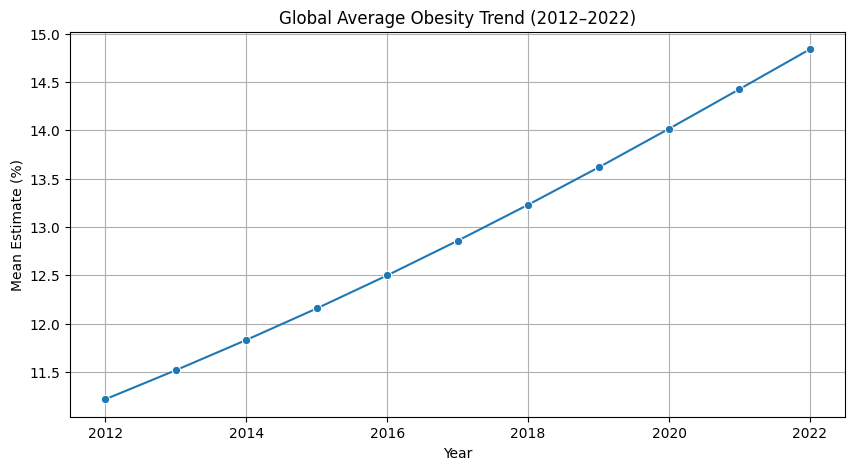

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
global_obesity = df_obesity.groupby('Year')['Mean_Estimate'].mean().reset_index()
sns.lineplot(data=global_obesity, x='Year', y='Mean_Estimate', marker='o')
plt.title("Global Average Obesity Trend (2012–2022)")
plt.ylabel("Mean Estimate (%)")
plt.grid()
plt.show()

C: Malnutrition Trend Over Years (Global Avg)

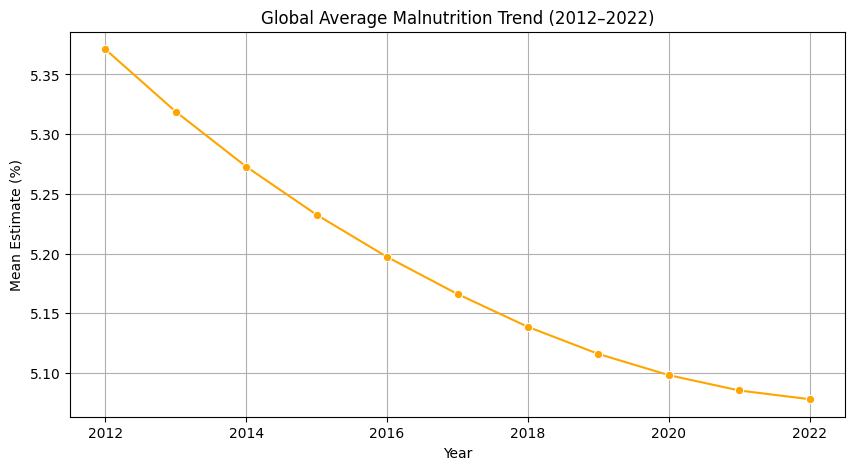

In [67]:
plt.figure(figsize=(10, 5))
global_malnutrition = df_malnutrition.groupby('Year')['Mean_Estimate'].mean().reset_index()
sns.lineplot(data=global_malnutrition, x='Year', y='Mean_Estimate', marker='o', color='orange')
plt.title("Global Average Malnutrition Trend (2012–2022)")
plt.ylabel("Mean Estimate (%)")
plt.grid()
plt.show()

**D: Gender-Based Average Comparison (Obesity vs Malnutrition)**

/tmp/ipython-input-68-1594804512.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mal_gender_avg, x='Gender', y='Mean_Estimate', ax=ax[1], palette='autumn')


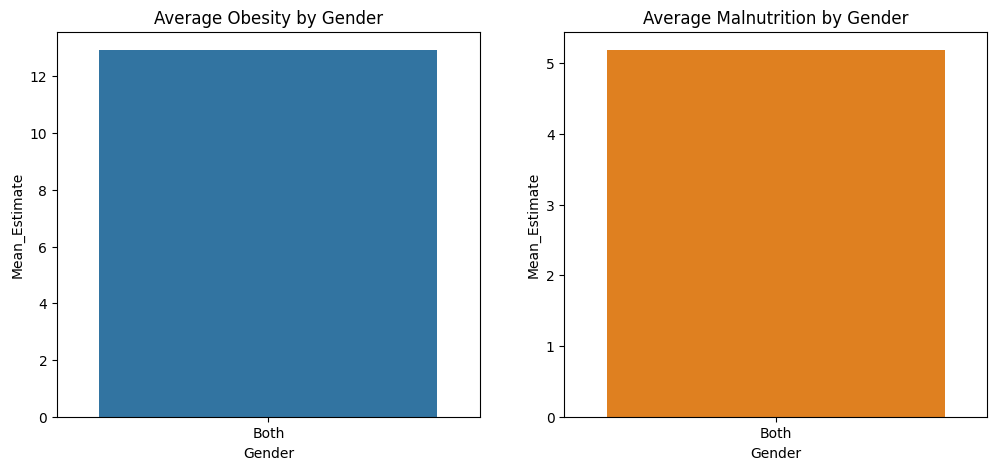

In [68]:
ob_gender_avg = df_obesity.groupby('Gender')['Mean_Estimate'].mean().reset_index()
mal_gender_avg = df_malnutrition.groupby('Gender')['Mean_Estimate'].mean().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=ob_gender_avg, x='Gender', y='Mean_Estimate', ax=ax[0])
ax[0].set_title("Average Obesity by Gender")

sns.barplot(data=mal_gender_avg, x='Gender', y='Mean_Estimate', ax=ax[1], palette='autumn')
ax[1].set_title("Average Malnutrition by Gender")

plt.show()

**E: Regional Variability– Boxplot by Region (Obesity)**

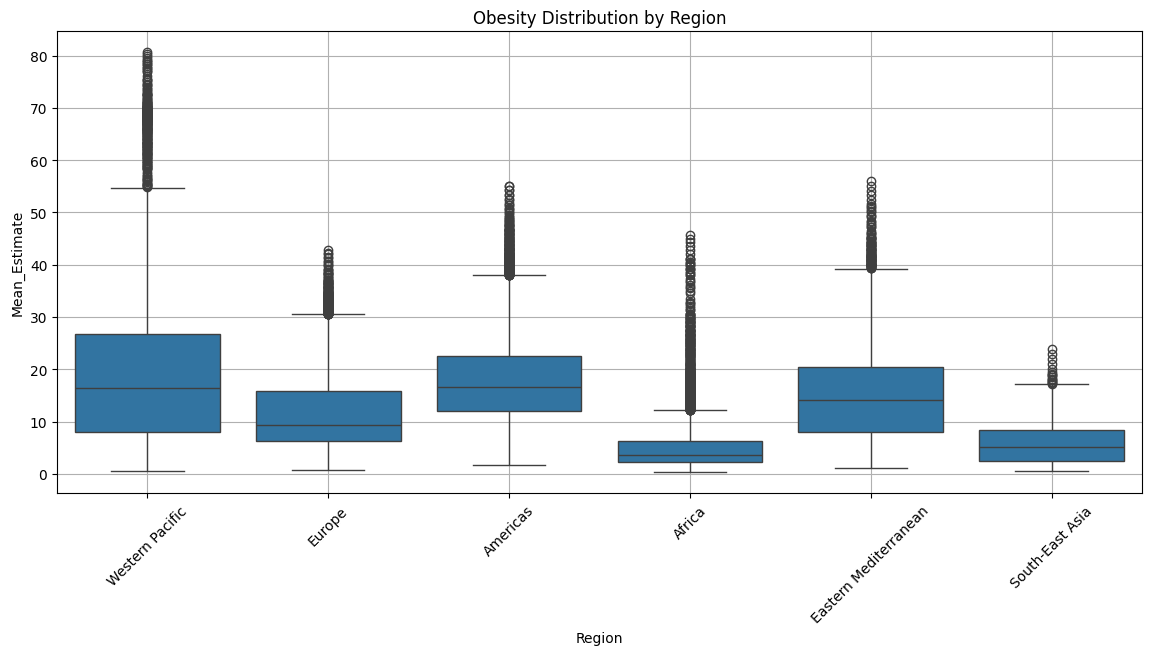

In [69]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_obesity, x='Region', y='Mean_Estimate')
plt.title("Obesity Distribution by Region")
plt.xticks(rotation=45)
plt.grid()
plt.show()

**F: Age Group Comparison– Obesity & Malnutrition**

/tmp/ipython-input-70-122641509.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_malnutrition, x='age_group', y='Mean_Estimate', ax=ax[1], palette='coolwarm')


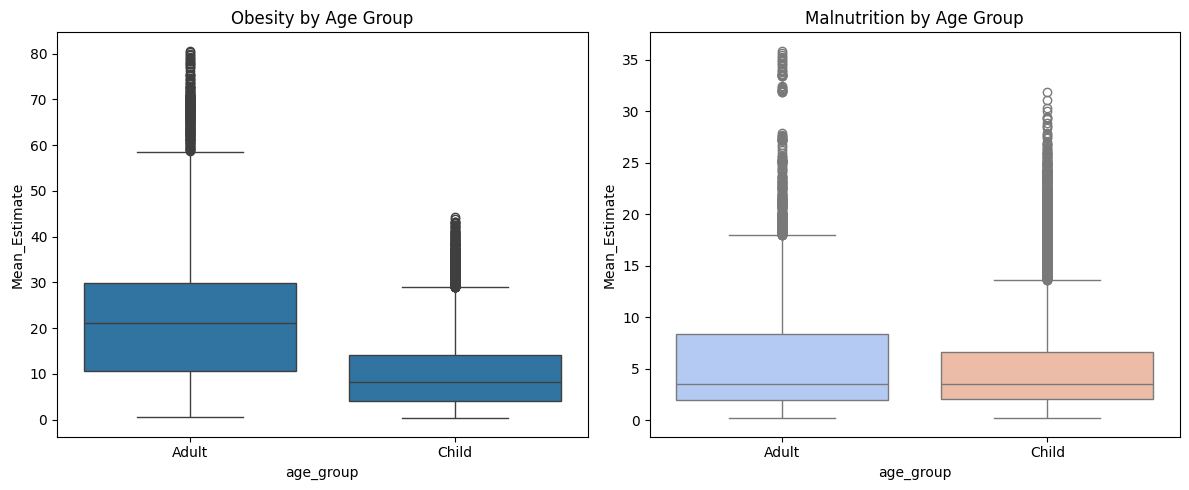

In [70]:
fig,ax= plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=df_obesity, x='age_group', y='Mean_Estimate', ax=ax[0])
ax[0].set_title("Obesity by Age Group")

sns.boxplot(data=df_malnutrition, x='age_group', y='Mean_Estimate', ax=ax[1], palette='coolwarm')
ax[1].set_title("Malnutrition by Age Group")

plt.tight_layout()
plt.show()

**G: Heatmap of CI_Width by Region & Year**

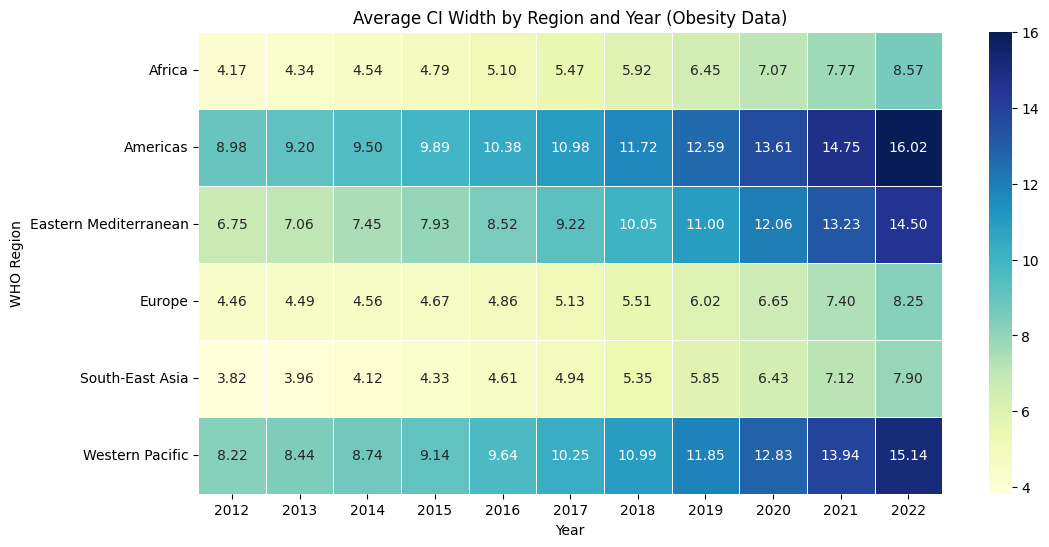

In [71]:
#Pivot the data: Region as rows, Year as columns
heatmap_data= df_obesity.pivot_table(values='CI_Width', index='Region', columns='Year', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Average CI Width by Region and Year (Obesity Data)")
plt.ylabel("WHO Region")
plt.xlabel("Year")
plt.show()

**H: Scatter Plot: Obesity vs Malnutrition (Merged by Country-Year)**

*(shows countries where obesity & malnutrition coexist)*

In [ ]:
#Merge datasets based on Country,year,gender and age group
merge_cols= ['Country', 'Year', 'Gender', 'age_group']

merged= pd.merge(
    df_obesity[merge_cols + ['Mean_Estimate']],
    df_malnutrition[merge_cols + ['Mean_Estimate']],
    on=merge_cols,
    suffixes=('_Obesity', '_Malnutrition'))
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged, x='Mean_Estimate_Obesity', y='Mean_Estimate_Malnutrition', hue='age_group')
plt.title("Obesity vs Malnutrition per Country-Year")
plt.xlabel("Obesity(%)")
plt.ylabel("Malnutrition(%)")
plt.grid()
plt.show()

**I: Countries with Extreme CI_Width**

*(Outliers in reliability)*

In [ ]:
#Group by Country, average CI Width
ci_summary=df_obesity.groupby('Country')['CI_Width'].mean().reset_index()
#Top 10 highest CI width
high_ci= ci_summary.sort_values('CI_Width', ascending=False).head(10)
print("Top 10 Countries with Highest Average CI Width (Obesity):")
print(high_ci)
#Top 10 lowest CI width
low_ci= ci_summary.sort_values('CI_Width').head(10)
print("\nTop 10 Countries with Lowest Average CI Width (Obesity):")
print(low_ci)

Top 10 Countries with Highest Average CI Width (Obesity):
                  Country   CI_Width
20                Bermuda  24.593417
3          American Samoa  23.113530
6     Antigua and Barbuda  22.016214
145           Puerto Rico  21.698679
72                Grenada  21.458487
170              Suriname  20.596436
179               Tokelau  20.451204
173  Syrian Arab Republic  20.157261
4                 Andorra  18.210110
153                 Samoa  18.115278

Top 10 Countries with Lowest Average CI Width (Obesity):
                Country  CI_Width
81                India  1.140133
89                Japan  1.155903
177         Timor-Leste  1.273569
28         Burkina Faso  1.531514
60             Ethiopia  1.589414
14           Bangladesh  1.663506
95   Korea, Republic of  2.016314
149              Rwanda  2.360579
142         Philippines  2.399143
37                China  2.399269


/tmp/ipython-input-28-510429020.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=high_ci, x='CI_Width', y='Country', palette='Reds_r')


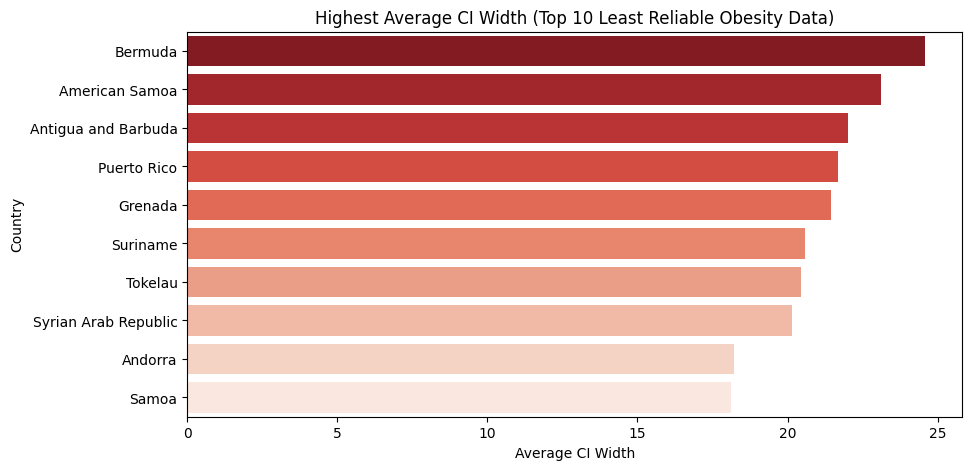

/tmp/ipython-input-28-510429020.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=low_ci, x='CI_Width', y='Country', palette='Greens')


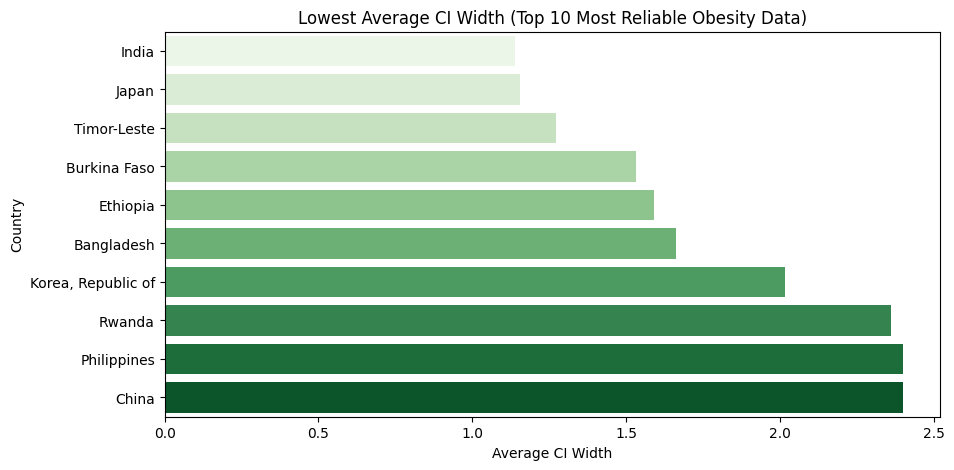

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=high_ci, x='CI_Width', y='Country', palette='Reds_r')
plt.title("Highest Average CI Width (Top 10 Least Reliable Obesity Data)")
plt.xlabel("Average CI Width")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=low_ci, x='CI_Width', y='Country', palette='Greens')
plt.title("Lowest Average CI Width (Top 10 Most Reliable Obesity Data)")
plt.xlabel("Average CI Width")
plt.show()

# **Step 4: A] SQL Insertion**

In [21]:
import sqlite3
conn = sqlite3.connect("nutrition_paradox.db")
cursor = conn.cursor()

In [22]:
cursor.execute("DROP TABLE IF EXISTS obesity")
cursor.execute("DROP TABLE IF EXISTS malnutrition")

#Create obesity table
cursor.execute("""
CREATE TABLE IF NOT EXISTS obesity(
    Year INTEGER,
    Gender TEXT,
    Mean_Estimate REAL,
    CI_Lower REAL,
    CI_Upper REAL,
    Age_Group TEXT,
    Country TEXT,
    Region TEXT,
    CI_Width REAL,
    Obesity_Level TEXT
)
""")
#Create malnutrition table
cursor.execute("""
CREATE TABLE IF NOT EXISTS malnutrition(
    Year INTEGER,
    Gender TEXT,
    Mean_Estimate REAL,
    CI_Lower REAL,
    CI_Upper REAL,
    Age_Group TEXT,
    Country TEXT,
    Region TEXT,
    CI_Width REAL,
    Malnutrition_Level TEXT
)
""")
conn.commit()

In [23]:
for index, row in df_obesity.iterrows():
    cursor.execute("""
        INSERT INTO obesity(
            Year, Gender, Mean_Estimate, CI_Lower, CI_Upper,
            Age_Group, Country, Region, CI_Width, Obesity_Level
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        row['Year'], row['Gender'], row['Mean_Estimate'], row['LowerBound'], row['UpperBound'],
        row['age_group'], row['Country'], row['Region'], row['CI_Width'],
        row.get('Obesity_Level')
    ))
conn.commit()

In [24]:
for index, row in df_malnutrition.iterrows():
    cursor.execute("""
        INSERT INTO malnutrition (
            Year, Gender, Mean_Estimate, CI_Lower, CI_Upper,
            Age_Group, Country, Region, CI_Width, Malnutrition_Level
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        row['Year'], row['Gender'], row['Mean_Estimate'], row['LowerBound'], row['UpperBound'],
        row['age_group'], row['Country'], row['Region'], row['CI_Width'],
        row.get('Malnutrition_Level')
    ))
conn.commit()

# **B] Obesity Table (10 Queries)**

**1. Top 5 regions with the highest average obesity levels in the most recent year (2022)**

In [35]:
import pandas as pd
query1="""
SELECT Region, ROUND(AVG(Mean_Estimate), 2) AS Avg_Obesity
FROM obesity
WHERE Year = 2022
GROUP BY Region
ORDER BY Avg_Obesity DESC
LIMIT 5;
"""

df = pd.read_sql_query(query1, conn)
df.head()
df.to_csv('/content/1top10_highest_average_obesity_levels2022.csv', index=False)

**2. Top 5 countries with highest obesity estimates**

In [ ]:
query2= """
SELECT Country, ROUND(AVG(Mean_Estimate), 2) AS Avg_Obesity
FROM obesity
GROUP BY Country
ORDER BY Avg_Obesity DESC
LIMIT 5;
"""

df = pd.read_sql_query(query2, conn)
df.head()
df.to_csv('/content/Top_5_countries_with_highest_obesity_estimates.csv', index=False)

**3. Obesity trend in India over the years (Mean_Estimate)**

In [ ]:
query3="""
SELECT Year, ROUND(AVG(Mean_Estimate), 2) AS India_Obesity
FROM obesity
WHERE Country='India'
GROUP BY Year
ORDER BY Year;
"""
df = pd.read_sql_query(query3, conn)
df
df.to_csv('/content/Obesity_trend_india.csv', index=False)

**4. Average obesity by gender**

In [ ]:
query4="""
SELECT Gender, ROUND(AVG(Mean_Estimate), 2) AS Avg_Obesity
FROM obesity
GROUP BY Gender;
"""
df = pd.read_sql_query(query4, conn)
df
df.to_csv('/content/avg_gender_obesity.csv', index=False)

**5. Country count by obesity level category and age group**

In [ ]:
query5= """
SELECT Obesity_Level, age_group, COUNT(DISTINCT Country) AS Country_Count
FROM obesity
GROUP BY Obesity_Level, age_group
ORDER BY Obesity_Level, age_group;
"""

df=pd.read_sql_query(query5, conn)
df
df.to_csv('/content/countrycount_obseitylevel_and_age.csv', index=False)

**6.Top 5 least reliable (highest CI_Width) and most consistent (lowest CI_Width) countries**

In [30]:
query6="""
SELECT Country, ROUND(AVG(CI_Width), 2) AS Avg_CI_Width
FROM obesity
GROUP BY Country
ORDER BY Avg_CI_Width DESC;
"""
#Unreliable
df1=pd.read_sql_query(query6, conn).head(5)
df1
df1.to_csv('/content/Upd_least_reliableCI.csv', index=False)

In [31]:
#Consistent
df2=pd.read_sql_query(query6, conn).tail(5)
df2
df2.to_csv('/content/UPD_most_reliableCI.csv', index=False)

**7. Average obesity by age group**

In [ ]:
df=query7="""
SELECT Age_Group, ROUND(AVG(Mean_Estimate), 2) AS Avg_Obesity
FROM obesity
GROUP BY Age_Group
ORDER BY Avg_Obesity DESC;
"""
df=pd.read_sql_query(query7, conn)
df.to_csv('/content/avg_Obesity_agegrp_wise.csv', index=False)

**8. Top 10 countries with consistent low obesity (low average + low CI)**

In [25]:
query8="""
SELECT Country, ROUND(AVG(Mean_Estimate),2) AS Avg_Obesity, ROUND(AVG(CI_Width),2) AS Avg_CI
FROM obesity
GROUP BY Country
HAVING Avg_Obesity<25 AND Avg_CI<2
ORDER BY Avg_Obesity ASC, Avg_CI ASC;
"""
df8=pd.read_sql_query(query8, conn)
df8
df8.to_csv('/content/111top10_lowest_obesity_countries.csv', index=False)

**9.Countries where female obesity exceeds male by large margin (same year)**

In [ ]:
query9="""
WITH GenderStats AS(SELECT Country, Year, Gender, AVG(Mean_Estimate) AS Avg_Obesity
  FROM obesity
  GROUP BY Country, Year, Gender)
SELECT f.Country, f.Year,
       ROUND(f.Avg_Obesity-m.Avg_Obesity, 2) AS Obesity_Gap
FROM GenderStats f
JOIN GenderStats m ON f.Country=m.Country AND f.Year=m.Year
WHERE f.Gender = 'Female' AND m.Gender = 'Male'
  AND Obesity_Gap>5
ORDER BY Obesity_Gap DESC;
"""
df=pd.read_sql_query(query9, conn)
df.to_csv('/content/female_obesity_more_than_male.csv', index=False)

**10. Global average obesity percentage per year**

In [ ]:
query10="""
SELECT Year, ROUND(AVG(Mean_Estimate), 2) AS Global_Avg_Obesity
FROM obesity
GROUP BY Year
ORDER BY Year;
"""
df=pd.read_sql_query(query10, conn)
df.to_csv('/content/Global_obesity_percent1.csv', index=False)

# **C] 10 Malnutrition Queries**
**1. Avg. malnutrition by age group**

In [ ]:
queryM1="""
SELECT age_group, ROUND(AVG(Mean_Estimate), 2) AS Avg_Malnutrition
FROM malnutrition
GROUP BY age_group
ORDER BY Avg_Malnutrition DESC;
"""
df1=pd.read_sql_query(queryM1, conn)
df1
df1.to_csv('/content/Avg_malnutrition_agewise.csv', index=False)

**2. Top 5 countries with highest malnutrition (mean_estimate)**

In [ ]:
query2="""
SELECT Country, ROUND(AVG(Mean_Estimate), 2) AS Avg_Malnutrition
FROM malnutrition
GROUP BY Country
ORDER BY Avg_Malnutrition DESC
LIMIT 5;
"""

df2=pd.read_sql_query(query2, conn)
df2
df2.to_csv('/content/top5_highest_malnutrition.csv', index=False)

**3. Malnutrition trend in African region over the years**

In [ ]:
query3="""
SELECT Year, ROUND(AVG(Mean_Estimate), 2) AS Avg_Malnutrition
FROM malnutrition
WHERE Region='Africa'
GROUP BY Year
ORDER BY Year;
"""
df3=pd.read_sql_query(query3, conn)
df3
df3.to_csv('/content/mal_africa.csv', index=False)

**4. Gender-based average malnutrition**

In [ ]:
query4="""
SELECT Gender, ROUND(AVG(Mean_Estimate), 2) AS Avg_Malnutrition
FROM malnutrition
GROUP BY Gender
ORDER BY Avg_Malnutrition DESC;
"""
df4=pd.read_sql_query(query4, conn)
df4
df4.to_csv('/content/gender_avg_mal.csv', index=False)

**5. Malnutrition level-wise average CI_Width by age group**

In [ ]:
query5="""
SELECT Malnutrition_Level, age_group, ROUND(AVG(CI_Width), 2) AS Avg_CI_Width
FROM malnutrition
GROUP BY Malnutrition_Level, age_group
ORDER BY Avg_CI_Width DESC;
"""
df5=pd.read_sql_query(query5, conn)
df5
df5.to_csv('/content/mal_level_avg_CIbyAge.csv', index=False)

**6. Yearly malnutrition change in India, Nigeria, Brazil**

In [ ]:
query6= """
SELECT Country, Year, ROUND(AVG(Mean_Estimate), 2) AS Avg_Malnutrition
FROM malnutrition
WHERE Country IN ('India', 'Nigeria', 'Brazil')
GROUP BY Country, Year
ORDER BY Country, Year;
"""
df6= pd.read_sql_query(query6, conn)
df6
df6.to_csv('/content/yeatly_mal_change_Ind_NI_BR.csv', index=False)

**7. Regions with lowest malnutrition averages**

In [27]:
query7="""
SELECT Region, ROUND(AVG(Mean_Estimate), 2) AS Avg_Malnutrition
FROM malnutrition
GROUP BY Region
ORDER BY Avg_Malnutrition ASC
LIMIT 5;
"""
df7=pd.read_sql_query(query7, conn)
df7
df7.to_csv('/content/upd_lowest_mal_avg.csv', index=False)

**8. Countries with increasing malnutrition (positive change over years)**

In [26]:
query8="""
SELECT Country, MIN(Mean_Estimate) AS Min_Malnutrition, MAX(Mean_Estimate) AS Max_Malnutrition, ROUND(MAX(Mean_Estimate)-MIN(Mean_Estimate), 2) AS Change
FROM malnutrition
GROUP BY Country
HAVING Change>0
ORDER BY Change DESC;
"""
df8=pd.read_sql_query(query8, conn)
df8
df8.to_csv('/content/11Countries_increasing_mal.csv', index=False)

**9. Min/Max malnutrition levels year-wise comparison**

In [ ]:
query9="""
SELECT Year, ROUND(MIN(Mean_Estimate), 2) AS Min_Malnutrition, ROUND(MAX(Mean_Estimate), 2) AS Max_Malnutrition
FROM malnutrition
GROUP BY Year
ORDER BY Year;
"""
df9=pd.read_sql_query(query9, conn)
df9
df9.to_csv('/content/min_max_mal_comparision.csv', index=False)

**10. High CI_Width flags for monitoring (CI_Width>5)**

In [ ]:
query10="""
SELECT Country, Year, Mean_Estimate, CI_Width
FROM malnutrition
WHERE CI_Width>5
ORDER BY CI_Width DESC;
"""
df10=pd.read_sql_query(query10, conn)
df10
df10.to_csv('/content/high_ci_width_flags.csv', index=False)

# **D] Combined Queries**

**1: Obesity vs Malnutrition comparison by country (any 5 countries)**

In [ ]:
queryC1="""
SELECT o.Country,
       ROUND(AVG(o.Mean_Estimate), 2) AS Avg_Obesity,
       ROUND(AVG(m.Mean_Estimate), 2) AS Avg_Malnutrition
FROM obesity o
JOIN malnutrition m ON o.Country = m.Country
WHERE o.Country IN ('India', 'Senegal', 'Brazil', 'Nigeria', 'Japan')
  AND m.Country IN ('India', 'Senegal', 'Brazil', 'Nigeria', 'Japan')
GROUP BY o.Country;
"""
df11=pd.read_sql_query(queryC1, conn)
df11
df11.to_csv('/content/ob_vs_mal.csv', index=False)

**2. Gender-based disparity in both obesity and malnutrition**

In [55]:
query2="""
SELECT o.Gender,
       ROUND(AVG(o.Mean_Estimate), 2) AS Avg_Obesity,
       ROUND(AVG(m.Mean_Estimate), 2) AS Avg_Malnutrition
FROM obesity o
JOIN malnutrition m ON o.Gender=m.Gender
GROUP BY o.Gender;
"""
df12=pd.read_sql_query(query2, conn)
df12
df12.to_csv('/content/gender_disparity_mal_vs_ob.csv', index=False)

KeyboardInterrupt: 

**3. Region-wise average estimates side-by-side (Africa and America)**

In [ ]:
query3="""
SELECT o.Region,
       ROUND(AVG(o.Mean_Estimate), 2) AS Avg_Obesity,
       ROUND(AVG(m.Mean_Estimate), 2) AS Avg_Malnutrition
FROM obesity o
JOIN malnutrition m ON o.Region = m.Region
WHERE o.Region IN ('Africa', 'Americas') AND m.Region IN ('Africa', 'Americas')
GROUP BY o.Region;
"""
df13= pd.read_sql_query(query3, conn)
df13
df13.to_csv('/content/region_wise_sidebyside.csv', index=False)

**4. Countries with obesity increasing & malnutrition decreasing**

In [34]:
query14="""
WITH obesity_change AS(
    SELECT Country,
           MIN(Year) AS Start_Year,
           MAX(Year) AS End_Year,
           MIN(Mean_Estimate) AS Min_Obesity,
           MAX(Mean_Estimate) AS Max_Obesity
    FROM obesity
    GROUP BY Country),
malnutrition_change AS(
    SELECT Country,
           MIN(Year) AS Start_Year,
           MAX(Year) AS End_Year,
           MIN(Mean_Estimate) AS Min_Malnutrition,
           MAX(Mean_Estimate) AS Max_Malnutrition
    FROM malnutrition
    GROUP BY Country)
SELECT o.Country,
       ROUND(o.Min_Obesity, 2) AS Start_Obesity,
       ROUND(o.Max_Obesity, 2) AS End_Obesity,
       ROUND(m.Min_Malnutrition, 2) AS Start_Malnutrition,
       ROUND(m.Max_Malnutrition, 2) AS End_Malnutrition
FROM obesity_change o
JOIN malnutrition_change m ON o.Country=m.Country
WHERE o.Max_Obesity>o.Min_Obesity AND m.Max_Malnutrition<m.Min_Malnutrition;
"""
df14=pd.read_sql_query(query14, conn)
df14
#df14.to_csv('/content/ob_inc_and_mal_dec.csv', index=False)

,Country,Start_Obesity,End_Obesity,Start_Malnutrition,End_Malnutrition


**5. Age-wise trend analysis**

In [ ]:
query15="""
SELECT o.age_group,
       ROUND(AVG(o.Mean_Estimate), 2) AS Avg_Obesity,
       ROUND(AVG(m.Mean_Estimate), 2) AS Avg_Malnutrition
FROM obesity o
JOIN malnutrition m ON o.age_group=m.age_group
GROUP BY o.age_group
ORDER BY o.age_group;
"""
df15=pd.read_sql_query(query15, conn)
df15
df15.to_csv('/content/age_wise_trends.csv', index=False)